In [6]:
import psycopg2
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import dotenv
import numpy as np
import random

In [2]:
dotenv.load_dotenv('.env', override=True)

True

In [4]:
# Connect to DB
conn = psycopg2.connect(
    f"dbname='{os.environ['POSTGRES_DB']}' user='{os.environ['POSTGRES_USER']}' "
    f"host='{os.environ['POSTGRES_HOST']}' password='{os.environ['POSTGRES_PASSWORD']}'"
)

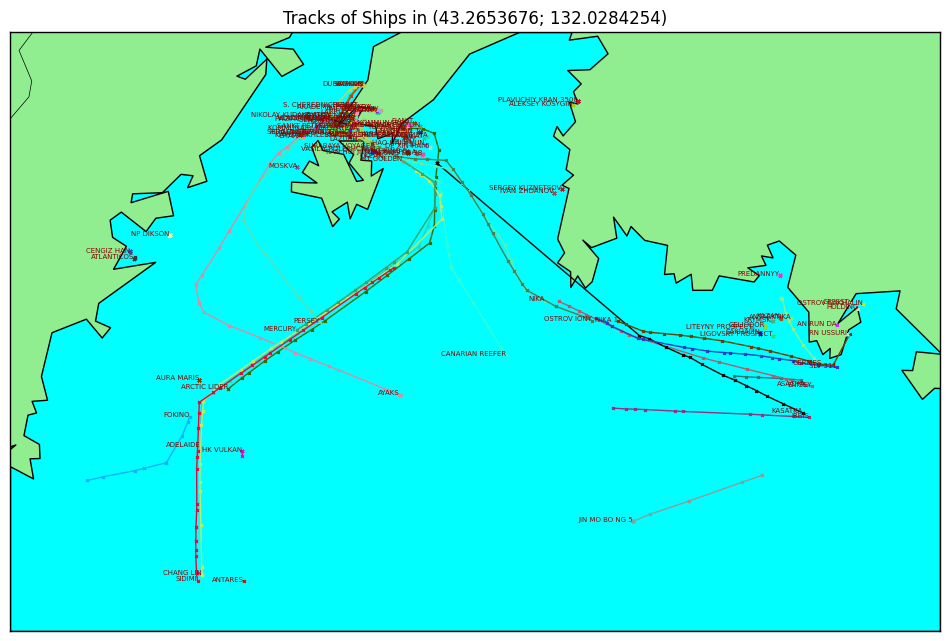

In [36]:
def showTracksInArea(lat_pos, lon_pos, radius=1, scale=1, show_names=True):
    random.seed(1)

    # Get ship data
    with conn.cursor() as cursor:
        cursor.execute(f"""
            SELECT ships.name, ships.id, location[0] AS latitude, location[1] AS longitude
            FROM positions
            JOIN ships ON positions.ship_id = ships.id
            WHERE positions.location <@ CIRCLE '(({lat_pos},{lon_pos}),{radius})'
              AND ships.width > 1
              AND positions.speed > 1
            ORDER BY ships.name, positions.added_date
        """)
        data = cursor.fetchall()

    # Sort ships
    ship_data = {}
    ship_names = {}
    for row in data:
        name, id, lat, lon = row
        if id not in ship_data:
            ship_data[id] = {'lats': [], 'lons': []}
            ship_names[id] = name
        ship_data[id]['lats'].append(lat)
        ship_data[id]['lons'].append(lon)

    # Render landscape
    plt.figure(figsize=(12, 10))
    all_lats = [lat for s in ship_data.values() for lat in s['lats']]
    all_lons = [lon for s in ship_data.values() for lon in s['lons']]
    lat_margin = (max(all_lats) - min(all_lats)) * scale
    lon_margin = (max(all_lons) - min(all_lons)) * scale

    m = Basemap(projection='merc',
                llcrnrlat=min(all_lats) - lat_margin, urcrnrlat=max(all_lats) + lat_margin,
                llcrnrlon=min(all_lons) - lon_margin, urcrnrlon=max(all_lons) + lon_margin,
                resolution='i')
    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='aqua')
    m.fillcontinents(color='lightgreen', lake_color='aqua')

    # Show ships tracks
    for id, ship_info in ship_data.items():
        color = (random.random(), random.random(), random.random())
        x, y = m(ship_info['lons'], ship_info['lats'])

        m.plot(x, y, marker='x', markersize=2, linewidth=1, color=color)

        if show_names:
          plt.text(x[len(x) - 1], y[len(y) - 1], f'{ship_names[id]}',
                      fontsize=5, color='darkred', ha='right')

    plt.title(f"Tracks of Ships in ({lat_pos}; {lon_pos})")
    plt.show()

showTracksInArea(43.2653676, 132.0284254, radius=1, scale=0.1)

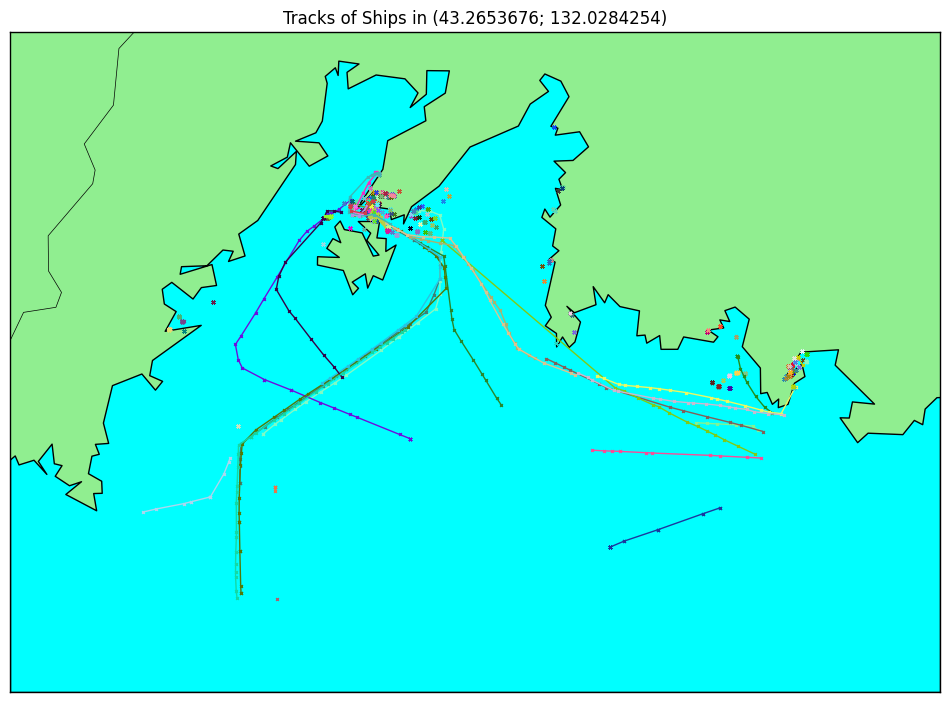

In [32]:
showTracksInArea(43.2653676, 132.0284254, radius=1, scale=0.2, show_names=False)

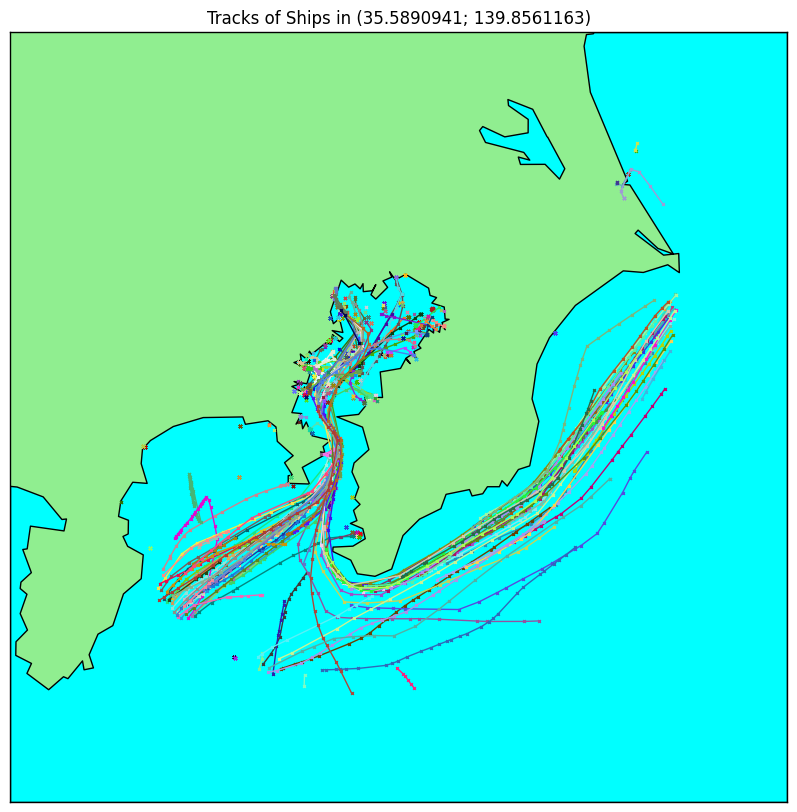

In [35]:
showTracksInArea(35.5890941, 139.8561163, radius=1, scale=0.2, show_names=False)

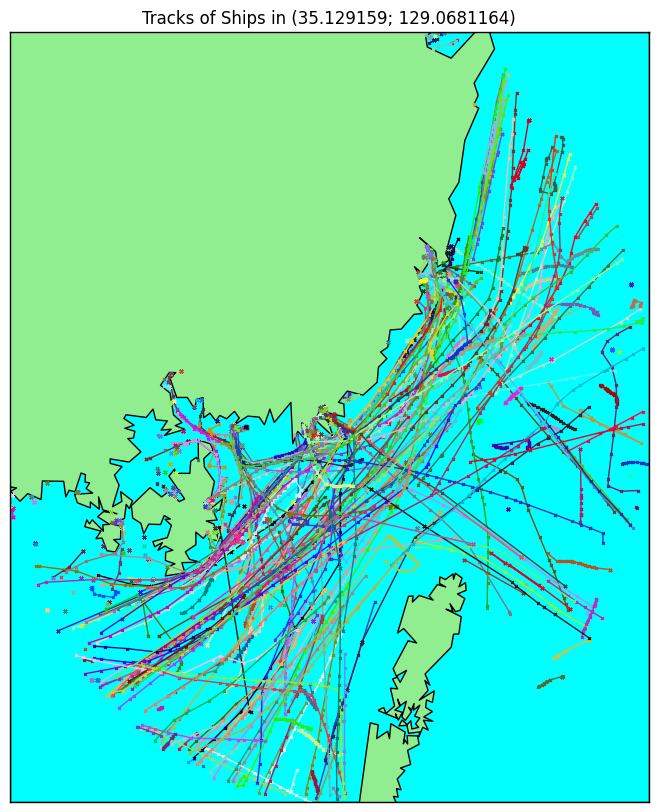

In [38]:
showTracksInArea(35.129159, 129.0681164, radius=1, scale=0.0, show_names=False)